In [1]:
import RNA
import numpy as np
from scipy.spatial import distance
import matplotlib.pyplot as plt

In [2]:
# If something in the full seq is paired to something which doesn't exist in the subseq
# Then I don't think it counts as a missfold if that nucleotide is unpaired in the subseq fold
def partial_ideal(ref):
    # First we identify unclosed opening brackets
    ref_transformed = []
    pstack = []
    for i, c in enumerate(ref):
        ref_transformed.append(c)
        if c == '(':
            pstack.append(i)
        if c == ')':
            pstack.pop()

    # And pretend those are unpaired.
    for i in pstack:
        ref_transformed[i] = '.'
    
    return(ref_transformed)

# Turn a db string into a dict
def dict_dot_bracket(db):
    open_stack = []
    pairs = {}
    for i, c in enumerate(db):
        if c == '(':
            open_stack.append(i)
        elif c == ')':
            j = open_stack.pop()
            pairs[i+1] = j+1 # ViennaRNA appears to be 1-indexed!
            pairs[j+1] = i+1

    return(pairs)

# Energy correction which penalizes base pairs which were not present in the last iteration
# The penalty is equal to ...% of the dinucleotide step which needs to be broken
# Cody suggests 1.5-2.5 kcal
def penalize_barriers(i, j, k, l, d, arg_dict):
    penalty = 100 # WHAT SHOULD THIS BE???
    if d in [RNA.DECOMP_PAIR_IL, RNA.DECOMP_PAIR_HP, RNA.DECOMP_PAIR_ML]:
        ref = arg_dict['last']
        if i in ref.keys():
            if ref[i] == j:
                return 0
            else:
                return penalty
            
    return 0

In [3]:
from IPython.display import IFrame

# Display in a Forna iframe
def forna_display(seq, struct, cols={}):
    col_str = '\\n'.join([f'{k}:{cols[k]}' for k in cols.keys()])
    # Can we run FORNA in a notebook (I feel like I've done this before...)
    forna_src = f'http://rna.tbi.univie.ac.at/forna/forna.html?id=url/name&sequence={seq}&structure={struct}&colors={col_str}'
    #generate a unique id for our iframe
    return IFrame(forna_src, 1300, 500)
    # That was easy.

In [4]:
md = RNA.md()
md.temperature = 37

In [5]:
f = 'SRP_test/SRP_RNAfold_design.txt'
with open(f, 'r') as design:
    name = design.readline().strip()
    target = design.readline().strip()
    seq = design.readline().strip()

# No pseudoknots in RNAsubopt
target = target.replace('[', '.')
target = target.replace(']', '.')

# Create subsequences, each 10 nt longer than the last.  Fold.
# Then compare the distance between the fold of the subseq to the truncated fold of the whole structure.
# This tries both a fresh fold of the whole subsequence, as well as a fold with soft constraints based on the MFE of the last iteration.
step_size = 1
boundspace = np.arange(10, len(seq)+step_size, step_size)

mins_comp = np.empty_like(boundspace)
maxes_comp = np.empty_like(boundspace)
meds_comp = np.empty_like(boundspace)
mfes_comp = np.empty_like(boundspace)
n_sub_comp = np.empty_like(boundspace)
mins_con = np.empty_like(boundspace)
maxes_con = np.empty_like(boundspace)
meds_con = np.empty_like(boundspace)
mfes_con = np.empty_like(boundspace)
n_sub_con = np.empty_like(boundspace)
mfe_diff = np.empty_like(boundspace)
last_structure = {}

to_save = {}

for i, bound in enumerate(boundspace):
    subseq = seq[:bound]
    subtarget = target[:bound]
    ref = partial_ideal(subtarget)

    ###################################
    #          complete fold          #
    ###################################
    fc = RNA.fold_compound(subseq, md)
    competing = fc.subopt(100)
        
    energies = [c.energy for c in competing]
    structures = [c.structure for c in competing]
    distances = [int(np.round(distance.hamming(list(s), ref) * len(ref))) for s in structures]
    min_idx = np.argmin(energies)
    mfe_comp = structures[min_idx]

    mins_comp[i] = min(distances)
    maxes_comp[i] = max(distances)
    meds_comp[i] = np.median(distances)
    mfes_comp[i] = distances[min_idx]
    n_sub_comp[i] = len(competing)

    if (bound-50 <= 0 and bound-50 > -step_size) or (bound-75 <= 0 and bound-75 > -step_size) or (bound-100 <= 0 and bound-100 > -step_size):
        to_save[f'comp_{bound}'] = (subseq, mfe_comp)

    ###################################
    #         constrained fold        #
    ###################################
    fc = RNA.fold_compound(subseq, md)

    step_info = {
        'last' : last_structure
    }

    fc.sc_add_f(penalize_barriers)
    fc.sc_add_data(step_info)

    competing = fc.subopt(100)

    distances = [int(np.round(distance.hamming(list(c.structure), ref) * len(ref))) for c in competing]
    energies = [c.energy for c in competing]
    structures = [c.structure for c in competing]

    min_idx = np.argmin(energies)
    mfe_con = structures[min_idx]
    last_structure = dict_dot_bracket(mfe_con)

    mins_con[i] = min(distances)
    maxes_con[i] = max(distances)
    meds_con[i] = np.median(distances)
    mfes_con[i] = distances[min_idx]
    n_sub_con[i] = len(competing)
    if (bound-50 <= 0 and bound-50 > -step_size) or (bound-75 <= 0 and bound-75 > -step_size) or (bound-100 <= 0 and bound-100 > -step_size):
        to_save[f'con_{bound}'] = (subseq, mfe_con)


    mfe_diff[i] = int(np.round(distance.hamming(list(mfe_comp), list(mfe_con)) * len(mfe_con)))
    print(f"Curr_length: {len(subseq)}, Comp_subs: {n_sub_comp[i]}, Con_subs: {n_sub_con[i]}, MFE_dist: {mfe_diff[i]}")

Curr_length: 10, Comp_subs: 1, Con_subs: 1, MFE_dist: 0
Curr_length: 11, Comp_subs: 1, Con_subs: 1, MFE_dist: 0
Curr_length: 12, Comp_subs: 1, Con_subs: 1, MFE_dist: 0
Curr_length: 13, Comp_subs: 3, Con_subs: 3, MFE_dist: 0
Curr_length: 14, Comp_subs: 3, Con_subs: 3, MFE_dist: 0
Curr_length: 15, Comp_subs: 3, Con_subs: 3, MFE_dist: 0
Curr_length: 16, Comp_subs: 3, Con_subs: 3, MFE_dist: 0
Curr_length: 17, Comp_subs: 5, Con_subs: 3, MFE_dist: 0
Curr_length: 18, Comp_subs: 9, Con_subs: 3, MFE_dist: 0
Curr_length: 19, Comp_subs: 11, Con_subs: 5, MFE_dist: 10
Curr_length: 20, Comp_subs: 7, Con_subs: 3, MFE_dist: 0
Curr_length: 21, Comp_subs: 4, Con_subs: 3, MFE_dist: 0
Curr_length: 22, Comp_subs: 2, Con_subs: 2, MFE_dist: 0
Curr_length: 23, Comp_subs: 3, Con_subs: 2, MFE_dist: 0
Curr_length: 24, Comp_subs: 5, Con_subs: 2, MFE_dist: 8
Curr_length: 25, Comp_subs: 4, Con_subs: 2, MFE_dist: 10
Curr_length: 26, Comp_subs: 3, Con_subs: 2, MFE_dist: 10
Curr_length: 27, Comp_subs: 3, Con_subs: 2, 

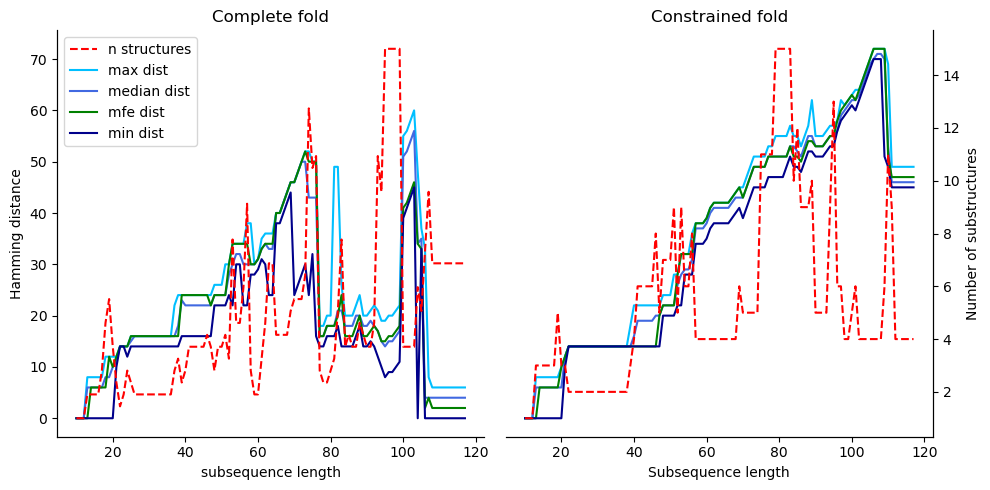

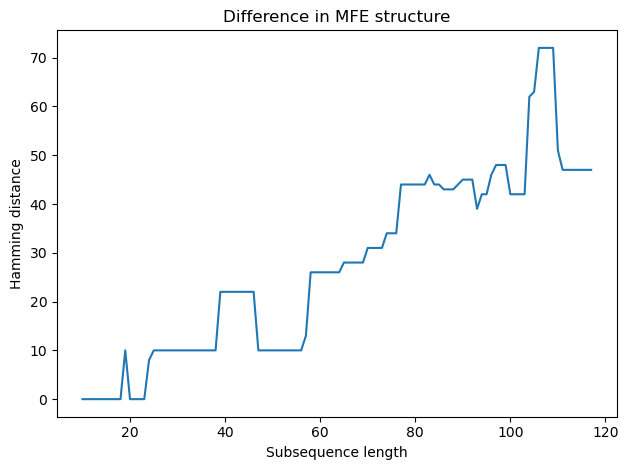

In [6]:
# let's plot the min, med and max and see that path to the final structure.
fig, ax = plt.subplots(1, 2, figsize=(10, 5))
a02 = ax[0].twinx()
ln1 = a02.plot(boundspace, n_sub_comp, 'r--', label='n structures')
ln2 = ax[0].plot(boundspace, maxes_comp, label='max dist', c='deepskyblue')
ln3 = ax[0].plot(boundspace, meds_comp, label='median dist', c='royalblue')
ln4 = ax[0].plot(boundspace, mfes_comp, label='mfe dist', c='g')
ln5 = ax[0].plot(boundspace, mins_comp, label='min dist', c='darkblue')
ax[0].set_title("Complete fold")
ax[0].set_xlabel("subsequence length")

lines = ln1 + ln2 + ln3 + ln4 + ln5
labs = [l.get_label() for l in lines]
ax[0].legend(lines, labs)

a12 = ax[1].twinx()
ln1 = a12.plot(boundspace, n_sub_con, 'r--', label='n structures')
ln2 = ax[1].plot(boundspace, maxes_con, label='max dist', c='deepskyblue')
ln3 = ax[1].plot(boundspace, meds_con, label='median dist', c='royalblue')
ln4 = ax[1].plot(boundspace, mfes_con, label='mfe dist', c='g')
ln5 = ax[1].plot(boundspace, mins_con, label='min dist', c='darkblue')
ax[1].set_xlabel("Subsequence length")
ax[1].set_title("Constrained fold")

#lines = ln1 + ln2 + ln3 + ln4 + ln5
#labs = [l.get_label() for l in lines]
#ax[1].legend(lines, labs)

# make first two plots share yscale
y_min = min([ax[0].get_ylim()[0], ax[1].get_ylim()[0]])
y_max = max([ax[0].get_ylim()[1], ax[1].get_ylim()[1]])
ax[0].set_ylim((y_min, y_max))
ax[1].set_ylim((y_min, y_max))
ax[0].set_ylabel("Hamming distance")
ax[0].spines[['right', 'top']].set_visible(False)
a02.spines[['right', 'top']].set_visible(False)
a02.set_yticks([])
a12.set_ylabel("Number of substructures")
ax[1].spines[['left', 'top']].set_visible(False)
a12.spines[['left', 'top']].set_visible(False)
ax[1].set_yticks([])

plt.tight_layout()
plt.savefig(f.strip('design.txt')+'kinetic.png', dpi = 200)

fig, ax = plt.subplots()
ax.plot(boundspace, mfe_diff)
ax.set_ylabel("Hamming distance")
ax.set_xlabel("Subsequence length")
ax.set_title("Difference in MFE structure")
plt.tight_layout()
plt.savefig(f.strip('design.txt')+'fold_diff.png', dpi = 200)

In [7]:
paper_colors = {14:'green', 31:'blue', 41:'purple', 57:'grey'}

In [8]:
forna_display(to_save['comp_50'][0], to_save['comp_50'][1], paper_colors)

In [9]:
forna_display(to_save['comp_75'][0], to_save['comp_75'][1], paper_colors)

In [10]:
forna_display(to_save['comp_100'][0], to_save['comp_100'][1], paper_colors)

In [11]:
forna_display(subseq, mfe_comp, paper_colors)

In [12]:
forna_display(to_save['con_50'][0], to_save['con_50'][1], paper_colors)

In [13]:
forna_display(to_save['con_75'][0], to_save['con_75'][1], paper_colors)

In [14]:
forna_display(to_save['con_100'][0], to_save['con_100'][1], paper_colors)

In [15]:
forna_display(subseq, mfe_con, paper_colors)